# Imports

In [1]:
import itertools
import math
import pandas as pd
import json
import os
import glob

from tqdm import tqdm
import seaborn as sns

import screed
import sklearn

%matplotlib inline

In [2]:
mouse_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse'    
human_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human'    


# Get ids of "good" reads to use for classification

## Subset to only reads from complete protein sequences -- *will not change with input species*

could maybe write these ids to file

In [8]:
# Quest for Orthologs data
qfo_2019 = '/home/olga/data_sm/immune-evolution/databases/quest-for-orthologs/2019'
qfo_eukaryota = f'{qfo_2019}/Eukaryota'


In [15]:
busco_mammalia_uniprot_protein_starts_with_m = []

# Use only the busco mammalia proteins
with screed.open(f'{qfo_eukaryota}/UP000005640_9606__busco_mammlia_odbv10.fasta') as records:
    for record in records:
        if record['sequence'].startswith("M"):
            busco_mammalia_uniprot_protein_starts_with_m.append(record['name'].split()[0].split('|')[1])
print('busco_mammalia_uniprot_protein_starts_with_m', len(busco_mammalia_uniprot_protein_starts_with_m))


uniprot_dna_starts_with_atg = []
with screed.open(f'{qfo_eukaryota}/UP000005640_9606_DNA.fasta') as records:
    for record in records:
        if record['sequence'].startswith("ATG"):
            uniprot_dna_starts_with_atg.append(record['name'].split()[0].split('|')[1])
print('uniprot_dna_starts_with_atg', len(uniprot_dna_starts_with_atg))

busco_mammalia_uniprot_protein_starts_with_m 8904
uniprot_dna_starts_with_atg 20336


In [16]:
uniprot_dna_starts_with_atg[:3]

['A0A024R161', 'A0A024R1R8', 'A0A024RBG1']

In [17]:
busco_mammalia_uniprot_protein_starts_with_m[:3]

['A0A087WTH1', 'A0A087WTH5', 'A0A087WWA1']

In [25]:
busco_mammalia_startswith_m__and__dna_startswith_atg = set(busco_mammalia_uniprot_protein_starts_with_m).intersection(uniprot_dna_starts_with_atg)
len(busco_mammalia_startswith_m__and__dna_startswith_atg)

8833

In [26]:
uniprot_dna_starts_with_atg[:3]

['A0A024R161', 'A0A024R1R8', 'A0A024RBG1']

## Read gold standard reading frame file

In [27]:
parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/true_reading_frames.parquet'

true_coding_frame = pd.read_parquet(parquet)
# Create just a series (single column) from this
true_coding_frame = true_coding_frame['is_coding']
true_coding_frame.head()

read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1      True
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=2     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=3     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-1    False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-2    False
Name: is_coding, dtype: bool

# Read coding score csvs

## Add read_id_frame and is_coding for computing metrics

In [28]:
def add_read_id_frame_and_is_coding(df):
    df['read_id_frame'] = df.read_id.astype(str) + '__frame=' + df.translation_frame.astype(str)
    df['is_coding'] = df['category'] == "Coding"
    return df

## Get human busco mammalia reads

In [29]:
human_busco_mammalia = pd.read_csv('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/busco_mammalia_human_uniprot_ids.csv')
print(human_busco_mammalia.shape)
human_busco_mammalia.head()

(22539, 3)


source__uniprot_id source__id_type  source__db_id
0             P61981         OrthoDB  1176818at2759
1             P27348         OrthoDB  1176818at2759
2             P30443         OrthoDB  1390181at2759
3             Q96QU6         OrthoDB  1156861at2759
4             P10321         OrthoDB  1390181at2759

## Function to read coding scores consistently

In [30]:
!hostname

ndnd


In [31]:
def read_translate_csvs(globber, species=None, 
                        human_busco_mammalia=human_busco_mammalia, 
                        uniprot_dna_starts_with_atg=uniprot_dna_starts_with_atg, 
                        true_coding_frame=true_coding_frame):
    dfs = []
    
    for filename in tqdm(glob.glob(globber)):
        dirname = os.path.dirname(filename)
        parent_dir = os.path.basename(dirname)
        molecule_, ksize_ = parent_dir.split('_')
        molecule = molecule_.split('-')[1]
        ksize = int(ksize_.split('-')[1])
        
        df = pd.read_csv(filename)
        df['alphabet'] = molecule
        df['ksize'] = ksize
        df['species'] = species 
        df = add_read_id_frame_and_is_coding(df)
        
        # Get only reads generated from busco mammalia data
        df['protein_id'] = df['read_id'].map(lambda x: x.split('/')[1].split(';')[0])
        df['uniprot_id'] = df['protein_id'].str.split('|').str[1]
        df = df.query('uniprot_id in @human_busco_mammalia.source__uniprot_id')
        
        # Get only reads from transcripts starting with ATG and no Ns, and only busco mammalia
        df = df.query('uniprot_id in @busco_mammalia_startswith_m__and__dna_startswith_atg')
        
        # Only use reads and frames in the gold standard data
        df = df.query('read_id_frame in @true_coding_frame.index')
        
        # Set the read id and frame as the row names
        df = df.set_index('read_id_frame')

        dfs.append(df)
    concatenated = pd.concat(dfs, ignore_index=False)
    concatenated = concatenated.sort_index()
    return concatenated

## Read human coding scores

In [32]:
! ls -lha $human_busco_dir/translate/molecule-dayhoff_ksize-10/

total 1.4G
drwxr-xr-x  2 olga czb 4.0K Oct  5 10:47 .
drwxr-xr-x 48 olga czb 8.0K Sep 30 17:54 ..
-rw-r--r--  1 olga czb  87M Oct  5 10:47 Homo_sapiens_9606_qfo_dna_01__molecule-dayhoff_ksize-10__coding_reads_nucleotides.fasta
-rw-r--r--  1 olga czb  53M Oct  5 10:47 Homo_sapiens_9606_qfo_dna_01__molecule-dayhoff_ksize-10__coding_reads_peptides.fasta
-rw-r--r--  1 olga czb 815M Oct  5 10:47 Homo_sapiens_9606_qfo_dna_01__molecule-dayhoff_ksize-10__coding_scores.csv
-rw-r--r--  1 olga czb 2.0K Oct  5 10:47 Homo_sapiens_9606_qfo_dna_01__molecule-dayhoff_ksize-10__coding_summary.json
-rw-r--r--  1 olga czb 417M Oct  5 10:47 Homo_sapiens_9606_qfo_dna_01__molecule-dayhoff_ksize-10__noncoding_reads_nucleotides.fasta


In [34]:
%%time

human_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human'    
!ls -lha $human_busco_dir
human_scores = read_translate_csvs(
    f'{human_busco_dir}/translate/*/*.csv', 
    species='human',
    human_busco_mammalia=human_busco_mammalia, 
    uniprot_dna_starts_with_atg=uniprot_dna_starts_with_atg, 
    true_coding_frame=true_coding_frame
)
print(human_scores.shape)
human_scores.head()

total 51M
drwxr-xr-x  8 olga czb 4.0K Sep 25 19:08 .
drwxr-xr-x  9 olga czb 4.0K Oct  2 09:04 ..
drwxr-xr-x  2 olga czb 8.0K Oct  5 15:04 blastp
-rw-r--r--  1 olga czb  51M Sep 25 19:08 correct_reading_frames.csv
drwxr-xr-x  2 olga czb 4.0K Oct  5 14:54 MultiQC
drwxr-xr-x  2 olga czb 4.0K Oct  5 10:29 ncbi_refseq
drwxr-xr-x  2 olga czb 4.0K Oct  5 15:04 pipeline_info
drwxr-xr-x  2 olga czb 8.0K Oct  5 10:30 sencha
drwxr-xr-x 48 olga czb 8.0K Sep 30 17:54 translate


100%|██████████| 46/46 [40:43<00:00, 53.11s/it]


(93634380, 12)
CPU times: user 17min 37s, sys: 46min 2s, total: 1h 3min 40s
Wall time: 1h 4min 50s


In [35]:
human_scores.head()

read_id  \
read_id_frame                                                                                           
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   

                                                    jaccard_in_peptide_db  \
read_id_frame                                                               
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   

                                                    n_kmers  \
read_id_frame                                                 
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   

                                                                               category  \
read_id_frame                                                                             
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   

                                                    translation_frame  \
read_id_frame                                                           
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   

                                                                              filename  \
read_id_frame                                                                            
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   

                                                   alphabet  ksize species  \
read_id_frame                                                                
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  protein     24   human   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  protein     13   human   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  dayhoff     15   human   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  dayhoff     13   human   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  protein     18   human   

                                                

### Write concatenated n frames per read, categorization to file

In [36]:
human_scores.to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate/coding_scores.parquet')

## Read mouse coding scores

In [38]:
%%time

mouse_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse'    
!ls -lha $mouse_busco_dir
mouse_scores = read_translate_csvs(
    f'{mouse_busco_dir}/translate/*/*.csv', 
    species='mouse',
    human_busco_mammalia=human_busco_mammalia, 
    uniprot_dna_starts_with_atg=uniprot_dna_starts_with_atg, 
    true_coding_frame=true_coding_frame
)
print(mouse_scores.shape)
mouse_scores.head()

total 19K
drwxr-xr-x  8 olga czb 4.0K Sep 22 18:48 .
drwxr-xr-x  9 olga czb 4.0K Oct  2 09:04 ..
drwxr-xr-x  2 olga czb 8.0K Oct  5 15:18 blastp
drwxr-xr-x  2 olga czb 4.0K Oct  5 15:09 MultiQC
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:44 ncbi_refseq
drwxr-xr-x  2 olga czb 4.0K Oct  5 15:18 pipeline_info
drwxr-xr-x  2 olga czb 8.0K Oct  5 10:51 sencha
drwxr-xr-x 48 olga czb 4.0K Sep 30 10:48 translate


100%|██████████| 46/46 [22:41<00:00, 29.61s/it]


(93634380, 12)
CPU times: user 18min 26s, sys: 13min 52s, total: 32min 19s
Wall time: 32min 44s


In [39]:
mouse_scores.head()

read_id  \
read_id_frame                                                                                           
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   

                                                    jaccard_in_peptide_db  \
read_id_frame                                                               
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   

                                                    n_kmers  \
read_id_frame                                                 
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   

                                                                               category  \
read_id_frame                                                                             
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   

                                                    translation_frame  \
read_id_frame                                                           
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   

                                                                              filename  \
read_id_frame                                                                            
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   

                                                   alphabet  ksize species  \
read_id_frame                                                                
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  protein     24   mouse   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  protein     13   mouse   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  dayhoff     15   mouse   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  dayhoff     13   mouse   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  protein     18   mouse   

                                                

In [40]:
human_scores.head()

read_id  \
read_id_frame                                                                                           
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...   

                                                    jaccard_in_peptide_db  \
read_id_frame                                                               
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                    NaN   

                                                    n_kmers  \
read_id_frame                                                 
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...      NaN   

                                                                               category  \
read_id_frame                                                                             
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Translation frame has stop codon(s)   

                                                    translation_frame  \
read_id_frame                                                           
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...                 -1   

                                                                              filename  \
read_id_frame                                                                            
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  Homo_sapiens_9606_qfo_dna_01.fq.gz   

                                                   alphabet  ksize species  \
read_id_frame                                                                
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  protein     24   human   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  protein     13   human   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  dayhoff     15   human   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  dayhoff     13   human   
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298...  protein     18   human   

                                                

In [41]:
human_scores.shape

(93634380, 12)

In [42]:
mouse_scores.shape

(93634380, 12)

### Check that human and mouse are not equal

In [43]:
(human_scores.jaccard_in_peptide_db == mouse_scores.jaccard_in_peptide_db).all()

False

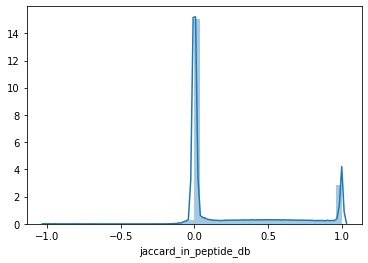

In [44]:
jaccard_diff = human_scores.jaccard_in_peptide_db.subtract(mouse_scores.jaccard_in_peptide_db)
sns.distplot(jaccard_diff.dropna())

### Write concatenated n frames per read, categorization to file

In [45]:
mouse_scores.to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores.parquet')

In [46]:
ls -lha '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores.parquet'

-rw-r--r-- 1 olga czb 745M Oct  5 17:10 /mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores.parquet
